# Comparing Integrated Gradients and Activation Patching



In [24]:
import importlib

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from captum.attr import IntegratedGradients
import pyvene as pv
import numpy as np

import toy_transformers.toy_bracket_transformer as tt
importlib.reload(tt)
from toy_transformers.toy_bracket_transformer import load_toy_bracket_transformer, test_loaded_bracket_model

In [25]:
tokenizer, model = load_toy_bracket_transformer()

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (hook_tokens): HookPoint()
  (blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out):

### Integrated gradients

To calculate the importance of a neuron or an attention head in the model, we use Integrated Gradients (IG).
- For a neuron, we compute the attribution scores of the inputs and project them by multiplying the attribution scores by the neuron's weight matrix. Neurons which focus on important inputs should have high importance scores.
- For an attention head, we compute the attribution scores of each attention head's output and take those as the importance scores.

In [130]:
bracket_transformer_target_layers = [
    model.embed, # Attribution of tokens
    model.blocks[0].attn.hook_result, # How much each attention head's outputs affect the final output
    model.blocks[0].ln2.hook_normalized, # Attribution of inputs to MLP first layer
    model.blocks[0].mlp.hook_post, # Attribution of inputs to MLP second layer
    model.blocks[1].attn.hook_result, 
    model.blocks[1].ln2.hook_normalized,
    model.blocks[1].mlp.hook_post,
    model.blocks[2].attn.hook_result, 
    model.blocks[2].ln2.hook_normalized,
    model.blocks[2].mlp.hook_post,
]

In [142]:
from captum.attr import LayerIntegratedGradients
import seaborn as sns
import matplotlib.pyplot as plt

def predict_unbalanced(x):
    logits = model(x)[:, 0]
    return logits.softmax(-1)[:, 0]


def compute_layer_to_output_attributions(target_layer, baseline):
    ig_embed = LayerIntegratedGradients(predict_unbalanced, target_layer)
    attributions, approximation_error = ig_embed.attribute(inputs=input,
                                                    baselines=baseline,
                                                    return_convergence_delta=True)

    print(f"\nError (delta) for {target_layer.name} attribution: {approximation_error.item()}")
    return attributions


def display_attributions(attributions, layer_name):
    attrs = attributions[0].detach().numpy() # assume only one batch as input
    ax = sns.heatmap(attrs, cmap="coolwarm", linewidths=0.5, center=0)
    plt.title(f"Importance scores of outputs from {layer_name}")
    plt.show()

In [143]:
def compute_layer_importance(target_layer, attributions):
    layer_name = target_layer.name
    if "embed" not in layer_name:
        layer_id = layer_name.removeprefix("blocks.")[0]
        layer_id = int(layer_id)
    if "hook_normalized" in layer_name:
        # Compute first layer MLP neuron importance by projection
        w_in = model.blocks[layer_id].mlp.W_in
        importance = (attributions @ w_in.T).abs().mean(dim=1)
    elif "hook_post" in layer_name:
        # Compute second layer MLP neuron importance by projection
        w_out = model.blocks[layer_id].mlp.W_out
        importance = (attributions @ w_out.T).abs().mean(dim=1)
    else:
        importance = attributions.abs()
    return importance



Error (delta) for embed attribution: -0.002693355083465576
torch.Size([1, 6, 56])


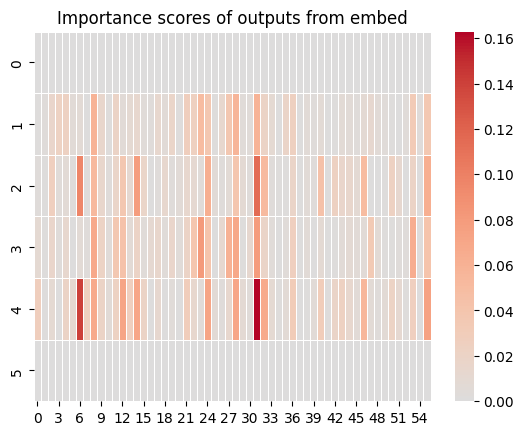


Error (delta) for blocks.0.attn.hook_result attribution: 0.06377953290939331
torch.Size([1, 6, 2, 56])

Error (delta) for blocks.0.ln2.hook_normalized attribution: -0.00153428316116333
torch.Size([1, 56])


IndexError: Inconsistent shape between the condition and the input (got (56, 1) and (56,))

In [ ]:
# Calculate integrated gradients for each layer

input = tokenizer.tokenize("()()")

# Set the baseline as a sequence of padding tokens except for start/end tokens:
# 1. Padding tokens (PAD_TOKEN) represent "no information" in the model's embedding space
# 2. We preserve start/end tokens to maintain the sequence structure
# 3. This creates a neutral reference point that only differs from the input in meaningful bracket positions
# 4. The attribution will then show how each bracket contributes relative to "no bracket"
mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
baseline = input * mask + tokenizer.PAD_TOKEN * (1 - mask)

importance_scores = dict()

for layer in bracket_transformer_target_layers:
    attributions = compute_layer_to_output_attributions(layer, baseline)
    # For non-embed layers, use zero activations as baseline
    importances = compute_layer_importance(layer, attributions)
    print(importances.shape)
    # TODO: make sure shapes are the same as activation patching
    importance_scores[layer.name] = importance_scores